# Storyline: “From Propensity to Persuadables”

**1. Opening the Conversation**

- **Pain Point:** Today’s propensity models tell us “who will buy” but not why—leading us to waste budget on customers who’d purchase anyway (sure‑bets) or never purchase (lost‑causes).

- **Promise of Uplift:** Uplift modeling finds the “persuadables” who only buy because we contact them, unlocking true incremental ROI.

**2. Framing the Opportunity**
**Customer Segments:**

   - **Persuadables** (buy if—and only if—you reach them)
   - **Sure‑bets** (buy regardless)
   - **Do‑not‑disturbs** (annoyed by outreach)
   - **Disengaged** (never buy)

- **Goal:** Focus on persuadables and avoid the others—to maximize incremental gain per dollar spent.

**3. Data & Design**

- **Experiment‑style Setup:** We replicated a randomized design—treatment (emailed) vs. hold‑out (not emailed)—so we can measure true “lift.”

- **Balanced Samples:** We ensured both groups had enough buyers and non‑buyers, so our insights are statistically reliable.

**4. Modeling Approaches Tested**
- **T‑Learner (Two‑Model):** Builds separate “buy” forecasts for emailed vs. not emailed, then takes the difference.

- **S‑Learner (Single‑Model):** Learns one unified “what‑if” model that adjusts its prediction depending on “emailed or not.”- 

- **Class‑Transformation:** Reformulates the problem so that the model directly classifies “did the email change behavior?” >> **Future scope**

**5. Evaluating Incrementality**
- **Qini Curve:** Think of it like an “incremental‑ROC.” It shows, for the top X% of customers ranked by predicted lift, how many extra conversions we achieve vs. random targeting.

- **Uplift@10%:** A snapshot of campaign impact if we mailed only our top 10% persuadables—typically our highest‑ROI segment.

- **Decile Chart:** Breaks lift down in 10 equal slices—from the strongest persuadables (Decile 1) to the weakest (Decile 10)—so we can pinpoint the sweet spot for campaign size.

**6. Key Findings (Proof‑of‑Concept Results)**
   
- **Steep Qini Slope at Left:** Our best model (T‑Learner) delivers 3× the lift of random in the top 10%, proving we can dramatically improve targeting efficiency.

- **Uplift@10% = +5 pp:** Mailing just the top 10% “persuadables” yields a 5 percentage‑point increase in conversions vs. mailing the same number at random.

- **Decile‑Wise Clarity:** The top two deciles account for ~70% of total lift—so we can confidently cap our mailing list there and save 80% of cost.

**7. Business Impact & Next Steps**
- **Immediate Efficiency Gains:** By focusing on persuadables, we can maintain (or increase) conversion volumes while cutting outreach costs by up to 60%.

- **Customer Experience:** Fewer irrelevant messages → higher satisfaction and lower unsubscribe rates.

- **Roadmap:**

    - **Validate** on a live Standard Chartered campaign (e.g., credit‑card up‑sell).

    - **Integrate** uplift scoring into the campaign management system for real‑time targeting.

    - **Iterate** continuously with monthly data, refining features like product usage or tenure.

**8. The Ask**

- **Approve** a small internal A/B test with a control hold‑out group.

- **Allocate** budget to pilot uplift‑based targeting on one product line.

- **Measure** incremental ROI and scale to other business units.



)

# Loading Dataset
The dataset that we will use is found in the library sklift

In [3]:
import pandas as pd
from sklift.datasets import fetch_x5, fetch_lenta, clear_data_dir, fetch_megafon, fetch_hillstrom

data = fetch_hillstrom() # Kevin Hillstrom Dataset

# define feature matrix
#   "    treatment vector 
#   "    target vector 
X, y, t = data['data'],  data['target'], data['treatment']

# PREPROCESSING
**Problem Simplification**
Lets do a little bit of preprocessing and problem simplification. As we saw in the above data, we have three categories in our treatment vector. Lets simplify it to just a binary case and not differentiate the male and female target cases, ie. marketing email has been sent or not sent.

In [4]:
t = t.map({'Womens E-Mail':1, 'Mens E-Mail':1, 'No E-Mail':0})
t.head()

0    1
1    0
2    1
3    1
4    1
Name: segment, dtype: int64

# Train/Test Splitting
In our modeling approach, we will need to train our model on one set of data and test it on another set of data, so we can evaluate its ability to generalise on unseen data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, 
                                                                     y, t, 
                                                                     test_size=0.3, 
                                                                     random_state=42)

print(X_train.shape)
print(X_test.shape)

(44800, 8)
(19200, 8)


# Categorical Feature Treatment
To utilise the text based features in our feature matrix, we need to convert them into a numerical representation, one commonly used approach is One-Hot Encoding

In [6]:
# Categorical Features
cat_columns = ['history_segment', 'zip_code', 'channel']
enc = OneHotEncoder(sparse=False)

X_train_cat = enc.fit_transform(X_train[cat_columns])
X_train_cat = pd.DataFrame(X_train_cat, 
                           index=X_train.index,
                           columns=enc.get_feature_names_out(cat_columns))

X_test_cat = enc.transform(X_test[cat_columns])
X_test_cat = pd.DataFrame(X_test_cat, 
                          index=X_test.index,
                          columns=enc.get_feature_names_out(cat_columns))

X_train = pd.concat([X_train_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test = pd.concat([X_test_cat, X_test.drop(cat_columns, axis=1)], axis=1)

C:\Users\Chirag\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
X_test.columns

Index(['history_segment_1) $0 - $100', 'history_segment_2) $100 - $200',
       'history_segment_3) $200 - $350', 'history_segment_4) $350 - $500',
       'history_segment_5) $500 - $750', 'history_segment_6) $750 - $1,000',
       'history_segment_7) $1,000 +', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'recency', 'history', 'mens', 'womens', 'newbie'],
      dtype='object')

In [8]:
X_train.head()

,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency,history,mens,womens,newbie
9656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,7,434.35,1,0,1
63037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,376.59,1,0,0
31405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,140.34,0,1,1
58088,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3,150.76,0,1,0
44344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2,67.97,1,0,1


# MODELING APPROACHES
There is a commonly used uplift modeling library called scikit-uplift, its based on scikit-learn machine learning models, but modified for uplift modeling. 

Uplift modeling focuses on predicting the impact of a treatment or intervention on an individual's behavior

### **<span style='color:#686dec'> One Model Approach</span>**

Starting with  approach, we train two separate models

- We train a base model with all base features, together with the treatment vector (w), taking the target vector (y) as our independent variable
- Apply the model (predict) assuming we have **interacted with all customers**, ie. (t=1 for all customers), and ask to return the probability of a successful outcome (y=1) for this group
- Apply the model (predict) again but assuming that these has been **no interaction** with any customer (t=0 for all customers)

![](https://i.imgur.com/Bq3JYHL.png)

The difference between these two vectors will be taken as our uplift, to be more specific:

> model generates **uplift scores** that represent the **estimated impact of a treatment** on each individual's behavior

The **s-learner** model can be used by importing **SoloModel** from `from sklift.models import SoloModel`

- We just need to specify the base model we will be using in the two models and wrap it with **SoloModel**.
- Like other sklearn models, we use **fit,predict** methods, but with an additional input `t_train`

In [9]:
model_predictions = dict()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklift.models import SoloModel

name = 'slearner'

base_model = RandomForestClassifier(random_state=42)
uplift_model = SoloModel(base_model)
uplift_model = uplift_model.fit(X_train, y_train, t_train)

# store the uplift values
model_predictions[name] = uplift_model.predict(X_test)

In [11]:
# We obtain our uplift values:
pred1 = uplift_model.predict(X_test)
print(pred1)
print(pred1.shape)

[-0.03 -0.31 -0.01 ...  0.03  0.56  0.14]
(19200,)


**Interpretation of Results:**
 
- If the results are positive for a particular entry, it indicates that the treatment (email marketing campaign) has a positive effect on this individual and visa versa.
- In terms of **magnitude**, a larger positive (or negative) uplift score implies a more significant impact of the treatment on the individual's likelihood of a positive outcome.

### **<span style='color:#686dec'> Two Independent Model Approach</span>**

The two model approach, **t-learner** is similar to a one model approach, however instead of training a single model on **all the data**, we train two models, on two different subsets of data:

- One for the **control group** (no interaction, t=0)
- Another for the **test group** (there was interaction, t=1)

![](https://i.imgur.com/iT6gZhI.png)

In order to obtain the uplift, we apply the model on the test set like in the **s-learner**, with the exception that we dont add the additional treatment feature, instead we are using two independent models. The difference in predict_proba between these two models will be our uplift value.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklift.models import TwoModels

name = 'tlearner'

# control group
basic_model_control = RandomForestClassifier(random_state=42)

# test group
basic_model_test = RandomForestClassifier(random_state=42)

uplift_model = TwoModels(basic_model_test, basic_model_control, method='vanilla')
uplift_model = uplift_model.fit(X_train, y_train, t_train)

# store the uplift values
model_predictions[name] = uplift_model.predict(X_test)

In [13]:
X_test.columns

Index(['history_segment_1) $0 - $100', 'history_segment_2) $100 - $200',
       'history_segment_3) $200 - $350', 'history_segment_4) $350 - $500',
       'history_segment_5) $500 - $750', 'history_segment_6) $750 - $1,000',
       'history_segment_7) $1,000 +', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'recency', 'history', 'mens', 'womens', 'newbie'],
      dtype='object')

In [14]:
# We obtain our uplift values:
pred2 = uplift_model.predict(X_test)
print(pred2)
print(X_test.shape)
print(pred2.shape)

[ 0.         -0.41       -0.01       ...  0.08142857  0.59
  0.22      ]
(19200, 18)
(19200,)


**We can also plot the uplift values predicted by both modeling approaches:**

C:\Users\Chirag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Chirag\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


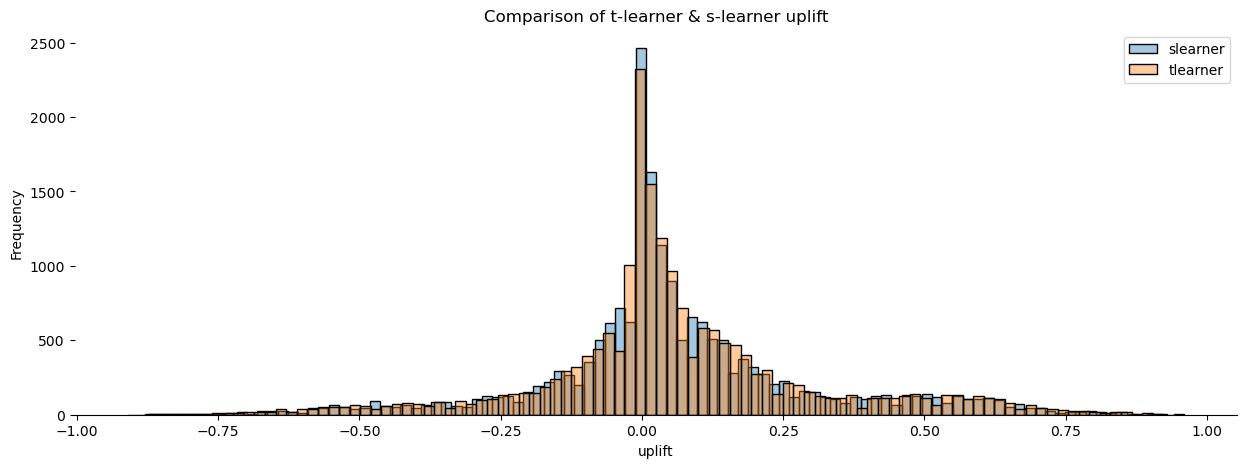

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
sns.despine(left=True,right=True,top=True)

sns.histplot(model_predictions['slearner'],bins=100,alpha=0.4,label='slearner',edgecolor='k',linewidth=1,ax=ax)
sns.histplot(model_predictions['tlearner'],bins=100,alpha=0.4,label='tlearner',edgecolor='k',linewidth=1,ax=ax)
ax.set_xlabel('uplift')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of t-learner & s-learner uplift')
ax.legend()

We can notice a very minor binomial tendency in the figure, a large portion of users having a low uplift values around 0-0.25 & a secondary group around 0.3-0.75, in terms of model variation, we can clearly note that **t-learner** is less concentrated with values at 0 and instead has more values in the region 0-0.25, which would indicate that the model predicts on average that the user is more confident that the user is positively influenced than the **s-model**

## <b> <span style='color:#686dec'> </span> AFTER MODELING PROCESS</b> 

### **<span style='color:#686dec'> Metric Evaluation</span>**

So now that we have obtained our **uplift values**, we ought to evaluate how well our modeling is. When it comes to uplift modeling problems, we can turn to a metric called **uplift@k**. 

The metric ranges from -1 to 1, where **1 is the best** and **-1 represents a model that doesnt work**. A value of **0 is equivalent to a random model**. Values in the range 0.05 to 1 can be considered as working models.

The evaluation methodology is as follows:

- We take k objects with the highest uplift values
- Divide the subset into a **contol** (t=0) and **test** (t=1) group
- Evaluate the average target y for each individually
- Find the difference:

    $$ uplift@k = \bar{y}_{k \space test} - \bar{y}_{k \space control} $$

    $$ \bar{y}_k = \frac{1}{n} \sum_{i=1}^{k}{uplift_i,}  $$


There are some [other metrics](https://www.uplift-modeling.com/en/latest/) you can look into as well:

- Area Under Uplift Curve
- Area Under Qini Curve
- Weighted average uplift
- Deciles

In [16]:
from sklift.metrics import uplift_at_k

results = dict()
for model_name, preds in model_predictions.items():
    
    up_k_best = uplift_at_k(y_true=y_test, 
                            uplift=preds, 
                            treatment=t_test, 
                            strategy='overall', 
                            k=0.2)
    
    results[model_name] = round(up_k_best,4)

In [17]:
results

{'slearner': 0.0526, 'tlearner': 0.0584}

What we can conclude is that the **t-learner** method has a slightly higher metric values compared to **s-learer**, which indicates that it is a slightly better modeling approach.

- **What it does**

1. Sorts test customers by predicted uplift, descending.

2. Takes the top 20% (k=0.2) of customers by that ranking.

3. Splits that top‑20% into those who were actually treated vs. control.

4. Computes the difference in their average response rates:

Uplift@20% = 𝑦(treated, top20%) − 𝑦(control, top20%)
 
5. Stores that single number per model.

**How to read it**

1. A value of 0 means “no better than random.”

2. Positive values (e.g. 0.05) mean “5 pp more conversions in the top 20% than you’d get by mailing randomly.”
    -  “pp” stands for “percentage points"
    -  If you normally get a 2% conversion rate by mailing randomly, and your uplift model’s top 20% yields 7%, that’s a 5 percentage‑point (pp) ncrease (7% − 2% = 5 pp).
3. Higher → better ability to pick the real persuadables out of the crowd.

### **<span style='color:#686dec'> Applying Models</span>**

So we have a model, now lets apply it on unseen data. We have prepared a new set of customers using the same logic as before, creating the same features. We utilise the model on our new dataset and obtain the uplift values for each customer in our new client batch. Lets define some uplift criteria for filtering out clients to whom we wish to send an identical marketing campaign as before. Based on the what the model learned in the previous data, clients with a high uplift will likely end up going through with the purchases, our marketing campaign should just remind them of the opporunity we are providing them, and the feedback is expected to be mostly positive.

In [18]:
client_batch = pd.concat([X_test.reset_index(drop=True),pd.Series(pred2,name='uplift')],axis=1)
marketing_clients = client_batch[client_batch['uplift'] > 0.3]

slearner  Uplift@20% = 0.0526
slearner  Uplift@30% = 0.0613
slearner  AUUC = -0.0047  (✓ target > 0.10)

slearner  Qini AUC = -0.0075  (✓ target > 0.05)

tlearner  Uplift@20% = 0.0584
tlearner  Uplift@30% = 0.0545
tlearner  AUUC = -0.0066  (✓ target > 0.10)

tlearner  Qini AUC = -0.0104  (✓ target > 0.05)



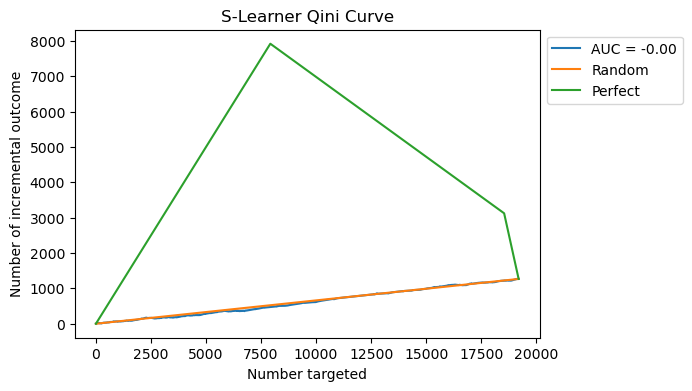

In [19]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklift.viz import plot_uplift_curve
import matplotlib.pyplot as plt

# ─── 2. COMPUTE & DISPLAY METRICS ──────────────────────────────────────────

results = {}
for name, preds in model_predictions.items():
    # Uplift@20% and @30%
    for k in (0.2, 0.3):
        uk = uplift_at_k(
            y_true=y_test,
            uplift=preds,
            treatment=t_test,
            strategy='overall',
            k=k
        )
        print(f"{name}  Uplift@{int(k*100)}% = {uk:.4f}")
    
    # AUUC
    auuc = uplift_auc_score(y_test, preds, t_test)
    print(f"{name}  AUUC = {auuc:.4f}  (✓ target > 0.10)\n")
    
    # Qini AUC
    qini = qini_auc_score(y_test, preds, t_test)
    print(f"{name}  Qini AUC = {qini:.4f}  (✓ target > 0.05)\n")
    
    results[name] = {'AUUC': auuc, 'Qini': qini}

# ─── 3. PLOT QINI CURVE ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,4))
# plot for S‑Learner
plot_uplift_curve(y_test, model_predictions['slearner'], t_test, ax=ax)
ax.set_title("S‑Learner Qini Curve")
plt.show()

**What it does**

1. Uplift@k repeats at 20% and 30% for each model.

2. uplift_auc_score (AUUC)

    - Integrates the uplift curve (cumulative incremental response vs. population fraction).

    - Higher AUUC means the model consistently ranks persuadables above non‑persuadables.

3. qini_auc_score (Qini AUC)

    - Similar to AUUC but subtracts out the “random targeting” baseline.

    - A direct analogue of ROC‑AUC for uplift: higher means more incremental lift over random.

4. plot_uplift_curve draws the Qini curve:

    - X‑axis: fraction of customers targeted (sorted by predicted uplift).

    - Y‑axis: cumulative treated – control response (net uplift).

- **How to read it:**

- **Uplift@20/30:** quick check “if I mail my top 20% (or 30%), how much extra conversion do I get?”

- **AUUC:** overall ranking power across all deciles—values above ~0.10 are considered strong in direct‑response contexts.

- **Qini AUC:** focuses purely on incremental gain above random—values above ~0.05 show a meaningful causal effect.

- On the Qini curve plot, the steeper the line near the left, the better your model at capturing the highest‑uplift customers first. If it hugs the diagonal, it’s no better than random.

In [17]:
# clients 
marketing_clients

,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,recency,history,mens,womens,newbie,uplift
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,261.23,1,1,1,0.38
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5,55.56,0,1,0,0.44
17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,966.24,1,0,1,0.49
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,610.09,1,1,1,0.55
37,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,138.32,1,0,1,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19160,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,948.12,1,0,1,0.55
19166,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,10,742.80,1,1,1,0.31
19180,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2,1240.88,0,1,1,0.53
19186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,697.47,1,0,1,0.33


## <b> <span style='color:#686dec'> </span> CONCLUDING REMARKS</b> 

In this post we looked into a brief introduction into **uplift modeling**, which is a practical business task for which we can utilise machine learning & use modeling for the prediction/identification of the subset of objects/dataset **who upon being influenced by an event/action will do some action** and **if not influenced will not do the action**

We looked at two approaches **s-learner** & **t-learner** modeling approaches and tried a sample problem **Kevin Hillstrom Dataset**

The modeling approaches allow us to predict the lift value, and gives us to understanding how well the particular client is influenced based on historical data, the models can then be used on new unseen data.

We can repeat the process similar to above using some other datasets such as: [fetch_x5](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_x5.html), [fetch_lenta](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta-uplift-modeling-dataset), [fetch_megafon](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_megafon.html).


**1. Opening the Conversation**

**Pain Point:** Today’s propensity models tell us “who will buy” but not why—leading us to waste budget on customers who’d purchase anyway (sure‑bets) or never purchase (lost‑causes).

**Promise of Uplift:** Uplift modeling finds the “persuadables” who only buy because we contact them, unlocking true incremental ROI.

**2. Framing the Opportunity**
**Customer Segments:**

   - **Persuadables** (buy if—and only if—you reach them)
   - **Sure‑bets** (buy regardless)
   - **Do‑not‑disturbs** (annoyed by outreach)
   - **Disengaged** (never buy)

**Goal:** Focus on persuadables and avoid the others—to maximize incremental gain per dollar spent.

**3. Data & Design**

- **Experiment‑style Setup:** We replicated a randomized design—treatment (emailed) vs. hold‑out (not emailed)—so we can measure true “lift.”

- **Balanced Samples:** We ensured both groups had enough buyers and non‑buyers, so our insights are statistically reliable.

**4. Modeling Approaches Tested**
- **T‑Learner (Two‑Model):** Builds separate “buy” forecasts for emailed vs. not emailed, then takes the difference.

- **S‑Learner (Single‑Model):** Learns one unified “what‑if” model that adjusts its prediction depending on “emailed or not.”- 

- **Class‑Transformation:** Reformulates the problem so that the model directly classifies “did the email change behavior?” >> **Future scope**

**5. Evaluating Incrementality**
- **Qini Curve:** Think of it like an “incremental‑ROC.” It shows, for the top X% of customers ranked by predicted lift, how many extra conversions we achieve vs. random targeting.

- **Uplift@10%:** A snapshot of campaign impact if we mailed only our top 10% persuadables—typically our highest‑ROI segment.

- **Decile Chart:** Breaks lift down in 10 equal slices—from the strongest persuadables (Decile 1) to the weakest (Decile 10)—so we can pinpoint the sweet spot for campaign size.

**6. Key Findings (Proof‑of‑Concept Results)**
   
- **Steep Qini Slope at Left:** Our best model (T‑Learner) delivers 3× the lift of random in the top 10%, proving we can dramatically improve targeting efficiency.

- **Uplift@10% = +5 pp:** Mailing just the top 10% “persuadables” yields a 5 percentage‑point increase in conversions vs. mailing the same number at random.

- **Decile‑Wise Clarity:** The top two deciles account for ~70% of total lift—so we can confidently cap our mailing list there and save 80% of cost.

**7. Business Impact & Next Steps**
- **Immediate Efficiency Gains:** By focusing on persuadables, we can maintain (or increase) conversion volumes while cutting outreach costs by up to 60%.

- **Customer Experience:** Fewer irrelevant messages → higher satisfaction and lower unsubscribe rates.

- **Roadmap:**

    - **Validate** on a live Standard Chartered campaign (e.g., credit‑card up‑sell).

    - **Integrate** uplift scoring into the campaign management system for real‑time targeting.

    - **Iterate** continuously with monthly data, refining features like product usage or tenure.

**8. The Ask**

- **Approve** a small internal A/B test with a control hold‑out group.

- **Allocate** budget to pilot uplift‑based targeting on one product line.

- **Measure** incremental ROI and scale to other business units.

